# Project 1: Momentum Resolution

In the following, all measurements are in metres, resp. radians.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar
from scipy.stats import norm
import scipy.stats as stats
import scipy.constants as const

## Tracking resolution

We modeled the uncertainty with /sqrt(12) - but we neglected the multiple scattering part.

### Single trajectory

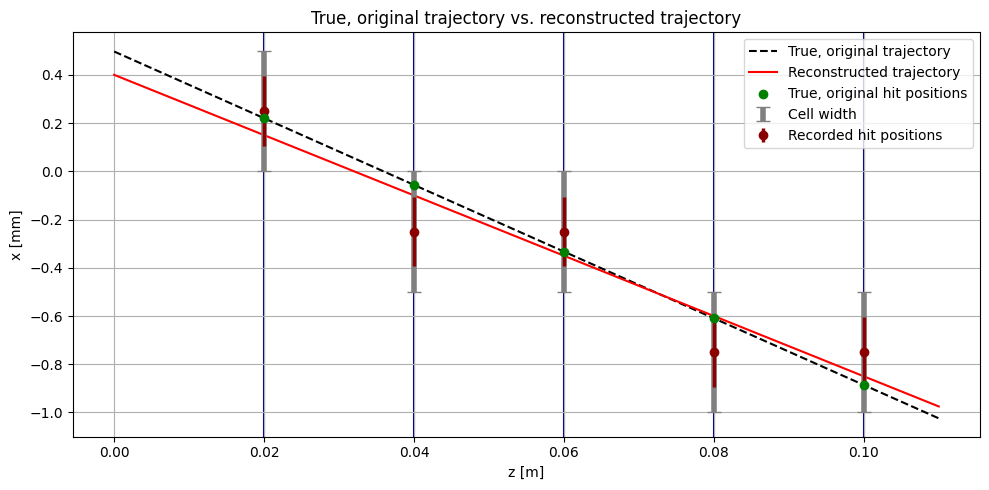

x0_true  = 0.497 mm
x0_reco  = 0.400 ± 0.151 mm
s0_true  = -0.014 rad
s0_reco  = -0.012 ± 0.002 rad


In [71]:
# Calculate the z and x positions of the planes 
# To use curve_fit, we need to have a function defined, so we use a function to calculate the x_positions
def trajectory_fun(z_position, x0, angle): 
    return x0 + z_position * np.tan(angle) # Calculating the vertical position using trigonometry

def trajectory_fun_linear(z_position, x0, slope): 
    return x0 + z_position * slope # Calculating the vertical position using trigonometry

def manual_least_squares(z, x, sigma):
    """Perform a weighted least squares linear fit to data (z, x),
    with constant uncertainty sigma (cell_width / np.sqrt(12)) on each x.
    Returns: x0_fit, slope_fit, std_x0, std_slope
    """
    w = np.ones_like(z) / sigma**2  # weights (array)

    # We want to minimise the weighted sum of residuals. 
    # For this we derive for x_0 and the slope and get two normal equations: 
    # sum( w_i * [x_i - x_0 - m*z_i]) = 0
    # sum( w_i * z_i * [x_i - x_0 - m*z_i]) = 0

    # Calculate the values of the important sums
    S_w = np.sum(w)
    S_wz = np.sum(w * z)
    S_wx = np.sum(w * x)
    S_wz2 = np.sum(w * z**2)
    S_wzx = np.sum(w * z * x)

    # Then 
    # S_wz = x_0 * S_w + m * S_wz = (S_w, S_wz) * (x_0, m)^T
    # S_wzx = x_0 * S_wz + m * S_wz2 = (S_wz, S_wz2) * (x_0, m)^T

    # We now solve this by multiplying the inverse of the matrix from the left to both sides (using the adjoint)
    # 1/det * (S_wz2 * S_wz - S_wz * S_wzx) = x0
    # 1/det * (-S_wz * S_wz + S_w * S_wzx) = slope = m

    # Calculate the determinant
    determinant_of_mat = S_w * S_wz2 - S_wz**2
    if determinant_of_mat <= 0:
        raise ValueError(f"Non-positive Delta encountered: {determinant_of_mat}")

    # Use the equations from above
    x0_fit = (S_wz2 * S_wx - S_wz * S_wzx) / determinant_of_mat
    slope_fit = (S_w * S_wzx - S_wz * S_wx) / determinant_of_mat

    # Covariance matrix is inverse of matrix
    # (S_w, S_wz)
    # (S_wz, S_wz2)

    # Again calculated with adjoint:
    # 1/det * (S_wz^2, - S_wz)
    #          (- S_wz, S_w)

    # Use the diagonal elements for the variance -> take root for std_err
    std_x0 = np.sqrt(S_wz2 / determinant_of_mat)
    std_slope = np.sqrt(S_w / determinant_of_mat)

    return x0_fit, slope_fit, std_x0, std_slope



def single_trajectory(n_planes = 5, delta_z = 0.02, cell_width = 0.0005):
    x0_true = np.random.normal(0, 0.001)
    s0_true = np.random.normal(0, 0.1)

    slope_true = np.tan(s0_true)

    z_positions = np.arange(1, n_planes + 1) * delta_z
    x_positions = trajectory_fun_linear(z_positions, x0_true, slope_true) 

    # Calculate which cell was hit
    cells_hit = np.floor(x_positions / cell_width) # Casting to int (.astype(int)) is optional; float cell indices suffice for midpoint computation; Also works if the x_position is negative -> e.g. cell "-1"
    cells_hit_middle = cells_hit * cell_width + cell_width / 2

    # Calculate the uncertainty
    std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia

    # Add Gaussian noise to simulate measurement uncertainty (realistic detector resolution)
    # Increases the uncertainty a lot - maybe not what we want
    # cells_hit_middle += np.random.normal(0, std_hit, size=cells_hit_middle.shape)

    """
    # Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
    popt, pcov = curve_fit(trajectory_fun_linear, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

    x0_reco, slope_reco = popt
    std_x0_reco, std_slope_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)
    """

    # Use weighted linear regression:
    x0_reco, slope_reco, std_x0_reco, std_slope_reco = manual_least_squares(z_positions, cells_hit_middle, std_hit)

    s0_reco = np.arctan(slope_reco)

    # We now do error propagation by using y = f(x) -> sigma_y = abs(df/dx (x_mean)) * sigma_x
    std_s0_reco = std_slope_reco / (1 + slope_reco**2) 

    return s0_true, s0_reco, std_s0_reco, slope_true, slope_reco, std_slope_reco, x0_true, x0_reco, std_x0_reco, z_positions, x_positions, cells_hit_middle, std_hit


n_planes = 5
delta_z = 0.02  # 2 cm in metres
cell_width = 0.0005  # 500 micrometers in metres
#z0 = 0 # not used

np.random.seed(42)

s0_true, s0_reco, std_s0_reco, slope_true, slope_reco, std_slope_reco, x0_true, x0_reco, std_x0_reco, z_positions, x_positions, cells_hit_middle, std_hit = single_trajectory()

# Plotting
grid = np.linspace(0, z_positions[-1] + delta_z/2, num = 1001)
true_traj_z = trajectory_fun(grid, x0_true, s0_true)  # Using the angle, because this was how the task was given
reco_traj_z = trajectory_fun_linear(grid, x0_reco, slope_reco) # Using the slope, because this was how we fitted

plt.figure(figsize=(10,5))
for z in z_positions:
    plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0) # Detector planes
# I multiplied everything by thousand such that the y-axis has millimetre values
plt.plot(grid, 1000*true_traj_z, "k--", label = "True, original trajectory") 
plt.plot(grid, 1000*reco_traj_z, "r-", label = "Reconstructed trajectory")
plt.scatter(z_positions, 1000*x_positions, color = "g", label = "True, original hit positions", zorder = 3)
plt.errorbar(z_positions, 1000*cells_hit_middle, yerr = 1000*cell_width/2, fmt='none', color='grey', elinewidth=4, capsize=5, label="Cell width")
plt.errorbar(z_positions, 1000*cells_hit_middle, yerr = 1000*std_hit, fmt = "o", color = "darkred", linewidth = 2.5, label = "Recorded hit positions")

plt.xlabel("z [m]")
plt.ylabel("x [mm]")
plt.grid()
plt.legend()
plt.title("True, original trajectory vs. reconstructed trajectory")
plt.tight_layout()
# plt.savefig("Single trajectory")
plt.show()


print(f"x0_true  = {x0_true*1000:.3f} mm")
print(f"x0_reco  = {x0_reco*1000:.3f} ± {std_x0_reco*1000:.3f} mm")
print(f"s0_true  = {s0_true:.3f} rad")
print(f"s0_reco  = {s0_reco:.3f} ± {std_s0_reco:.3f} rad")



### Multiple trajectories

We first tried to fit the trajectory with curve_fit. First, we fitted with modelling the uncertainty the direct way, but because tan(s0) is nonlinear, the impact of errors in s0 grows with s0, and the uncertainty model of curve_fit doesn’t fully capture that, so the unlinearity of tan(s0) lead to a strong underestimation of the uncertainty of s0. <br> <br>

Next, we tried fitting with curve_fit, but introducing the linear function trajectory_fun_linear to get rid of the nonlinearity of the tangent (of course, there was a certain preparation and postprocessing of the data). The uncertainty was less underestimated, but still present to a significant extent. <br> <br>

Finally, we decided to fit the linear data ourselves by creating a function that would do a weighted linear regression based on the least squares criterion. The uncertainties are now represented very well (though it takes a lot longer). <br> <br>

Note that this underestimation of the uncertainty was always visible by the too large standard deviation of the pulls - especially of those of the angle.

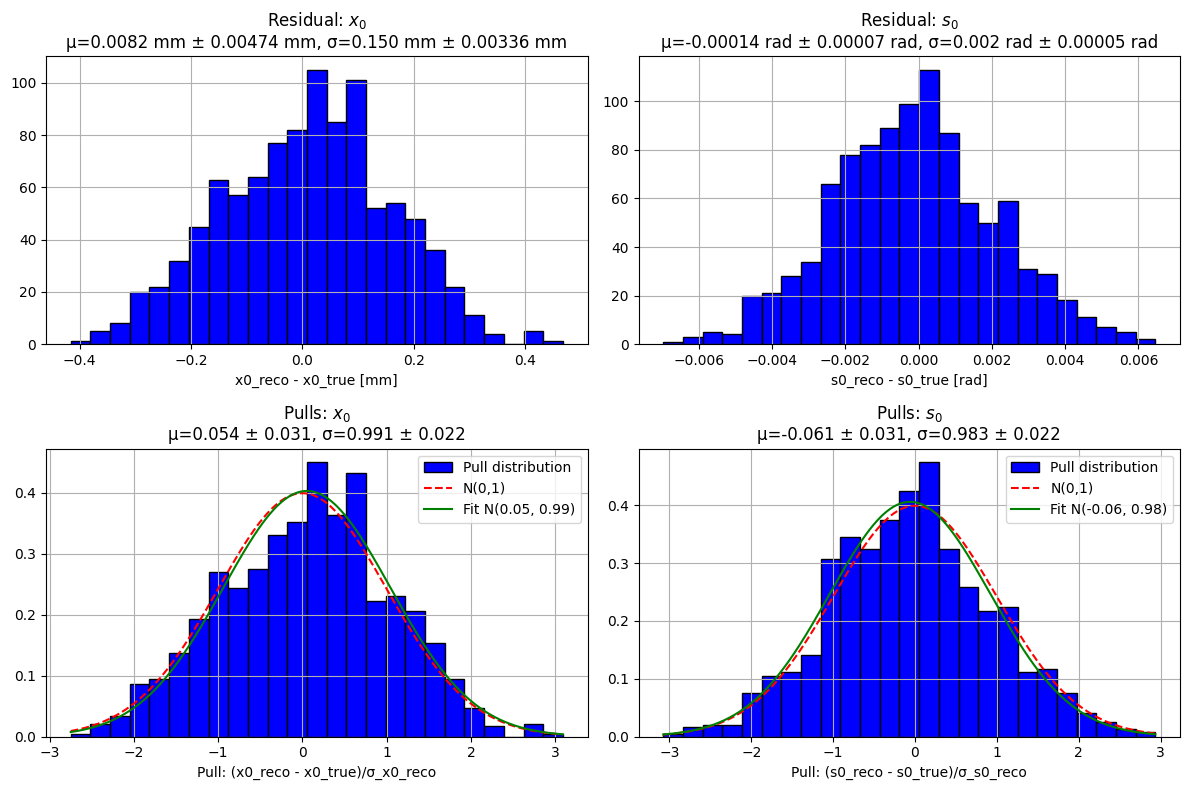

In [72]:
n_trajectories = 1000
delta_z = 0.02  # 2 cm in metres
n_planes = 5
cell_width = 0.0005  # 500 micrometers in metres
#z0 = 0 # not used


np.random.seed(42)

# Arrays for the residuals and for the pulls
resi_s0 = np.full(n_trajectories, np.nan)
resi_x0 = np.full(n_trajectories, np.nan)

pulls_s0 = np.full(n_trajectories, np.nan)
pulls_x0 = np.full(n_trajectories, np.nan)


for i in range(n_trajectories):
    # Get single trajectory
    s0_true, s0_reco, std_s0_reco, slope_true, slope_reco, std_slope_reco, x0_true, x0_reco, std_x0_reco, z_positions, x_positions, cells_hit_middle, std_hit = single_trajectory()

    # Residuals
    resi_s0[i] = s0_reco - s0_true
    resi_x0[i] = x0_reco - x0_true

    # pull = (reconstructed_quantity - generated_quantity)/uncertainty_on_reconstructed_quantity
    pulls_s0[i] = (s0_reco - s0_true)/std_s0_reco
    pulls_x0[i] = (x0_reco - x0_true)/std_x0_reco


# Taking the mean and standard deviation for the residuals
mean_resi_s0 = np.mean(resi_s0)
mean_resi_x0 = np.mean(resi_x0)

std_resi_s0 = np.std(resi_s0)
std_resi_x0 = np.std(resi_x0)


# Uncertainties of estimators of residuals assuming gaussian distribution
mean_resi_s0_error = std_resi_s0/np.sqrt(n_trajectories)
mean_resi_x0_error = std_resi_x0/np.sqrt(n_trajectories)
std_resi_s0_error = std_resi_s0/np.sqrt(2 * n_trajectories - 2)
std_resi_x0_error = std_resi_x0/np.sqrt(2 * n_trajectories - 2)


# 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot these distributions as histograms
axs[0, 0].hist(resi_x0 * 1000, bins = 25, color = "blue", edgecolor = "black")
axs[0, 0].set_title(f"Residual: $x_0$\nμ={mean_resi_x0 * 1000:.4f} mm ± {mean_resi_x0_error * 1000:.5f} mm, σ={std_resi_x0 * 1000:.3f} mm ± {std_resi_x0_error * 1000:.5f} mm")
axs[0, 0].set_xlabel("x0_reco - x0_true [mm]")
axs[0, 0].grid()

axs[0, 1].hist(resi_s0, bins = 25, color = "blue", edgecolor = "black")
axs[0, 1].set_title(f"Residual: $s_0$\nμ={mean_resi_s0:.5f} rad ± {mean_resi_s0_error:.5f} rad, σ={std_resi_s0:.3f} rad ± {std_resi_s0_error:.5f} rad")
axs[0, 1].set_xlabel("s0_reco - s0_true [rad]")
axs[0, 1].grid()


# Taking the mean and standard deviation for the pulls
mean_pulls_s0 = np.mean(pulls_s0)
mean_pulls_x0 = np.mean(pulls_x0)

std_pulls_s0 = np.std(pulls_s0)
std_pulls_x0 = np.std(pulls_x0)


# Uncertainties of estimators of pulls assuming gaussian distribution
mean_pulls_s0_error = std_pulls_s0/np.sqrt(n_trajectories)
mean_pulls_x0_error = std_pulls_x0/np.sqrt(n_trajectories)
std_pulls_s0_error = std_pulls_s0/np.sqrt(2 * n_trajectories - 2)
std_pulls_x0_error = std_pulls_x0/np.sqrt(2 * n_trajectories - 2)


# Plot the distributions as histograms with overlayed Gaussian distributions
axs[1, 0].hist(pulls_x0, bins=25, density=True, color="blue", edgecolor="black", label="Pull distribution")
x_vals = np.linspace(min(pulls_x0), max(pulls_x0), 500)
axs[1, 0].plot(x_vals, norm.pdf(x_vals, 0, 1), 'r--', label="N(0,1)")
axs[1, 0].plot(x_vals, norm.pdf(x_vals, mean_pulls_x0, std_pulls_x0), 'g-', label=f"Fit N({mean_pulls_x0:.2f}, {std_pulls_x0:.2f})")
axs[1, 0].set_title(f"Pulls: $x_0$\nμ={mean_pulls_x0:.3f} ± {mean_pulls_x0_error:.3f}, σ={std_pulls_x0:.3f} ± {std_pulls_x0_error:.3f}")
axs[1, 0].set_xlabel("Pull: (x0_reco - x0_true)/σ_x0_reco")
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].hist(pulls_s0, bins=25, density=True, color="blue", edgecolor="black", label="Pull distribution")
x_vals = np.linspace(min(pulls_s0), max(pulls_s0), 500)
axs[1, 1].plot(x_vals, norm.pdf(x_vals, 0, 1), 'r--', label="N(0,1)")
axs[1, 1].plot(x_vals, norm.pdf(x_vals, mean_pulls_s0, std_pulls_s0), 'g-', label=f"Fit N({mean_pulls_s0:.2f}, {std_pulls_s0:.2f})")
axs[1, 1].set_title(f"Pulls: $s_0$\nμ={mean_pulls_s0:.3f} ± {mean_pulls_s0_error:.3f}, σ={std_pulls_s0:.3f} ± {std_pulls_s0_error:.3f}")
axs[1, 1].set_xlabel("Pull: (s0_reco - s0_true)/σ_s0_reco")
axs[1, 1].legend()
axs[1, 1].grid()


plt.tight_layout()
# plt.savefig("Multiple trajectories")
plt.show()
    

## Momentum resolution

### Setup
The experimental apparatus is constructed with the z-axis horizontal, the x-axis vertical and the y-axis perpendicular to the drawing of the experiment (i.e. exiting the screen).
z positive to the right, x positive upwards and y positive exiting in the direction of the person looking at the drawing.

The experiment setup consists of five detection planes placed along the z-axis, parallel to the x-axis, and placed 2cm apart.
The magnetic field is directed towards the positive y-axis, with an intensity of 0.5T, and is 10cm long along the z-axis. At the end of the magnetic field
there are three detection planes, also parallel to the x-axis and placed 2cm apart.

In [ ]:
# Variables
n_beforeB = 5              # number of detections planes before the magnetic field
n_afterB = 3               # number of detections planes after the magnetic field
D_z = 2e-2                 # distance between the two planes along z-axis in m
L = 10e-2                  # length of the magnetic field along z_axis in m
B = 0.5                    # magnetic field intensity in T
cell_width = 0.0005        # 500 micrometers in metres
z_start_after_B = n_beforeB*D_z + L      # position of the first plane after B field in m
pT_true = 0.3e9                # transverse momentum in GeV
nr_trajectories = 10

# Constants
#q = const.e                # charge of the electron in CC

In [74]:
# Functions

def trajectory_before_B(z, starting_xpoint, starting_angle):
    return starting_xpoint + np.tan(starting_angle) * z

def trajectory_before_B_linear(z, starting_xpoint, slope): 
    return starting_xpoint + z * slope


def generating_x0(n):
    mean_x = 0
    std_x = 1e-3             # in metres
    x0 = np.random.normal(loc=mean_x, scale=std_x, size=n) # Generate n random starting positions
    
    #for i in range(n):
        #x0.append(stats.norm.rvs(loc=mean_x, scale=std_x))
    
    return x0

def generating_s0(n):
    mean_s = 0
    std_s = 0.1             # rad
    s0 = np.random.normal(loc=mean_s, scale=std_s, size=n)
    # Generate n random angles
    #for i in range(n):
        #s0.append(stats.norm.rvs(loc=mean_s, scale=std_s))
    return s0

""" Computes and returns the points of the circular path given the starting point, radius, length along z-axis and slope of the first line."""
def circular_path_coefficients(x_start, z_start, radius, L, slope_first_line, charge):
    
    x_center = 0
    z_center = 0
    angle_first_line = np.arctan(slope_first_line)  # in rad
    
    # Radiant angle
    #theta = np.cos(angle_first_line)*L / radius  # in rad
    
    # Circle center coordinates
    if slope_first_line > 0:
        z_center = z_start + radius * np.sin(angle_first_line)
        x_center = x_start - radius * np.cos(angle_first_line)
    else:
        z_center = z_start - radius * np.sin(angle_first_line)
        x_center = x_start + radius * np.cos(angle_first_line)
    
    
    # If the charge is negative, reflect the center about the incoming trajectory
    if charge < 0:
        # Unit direction vector of incoming trajectory
        dz = 1 / np.sqrt(1 + slope_first_line**2)
        dx = slope_first_line * dz

        # Normal vector to the line (perpendicular)
        nx = -dz
        nz = dx

        # Vector from (x_start, z_start) to center
        vx = x_center - x_start
        vz = z_center - z_start

        # Projection of v onto the normal
        dot = vx * nx + vz * nz
        proj_x = 2 * dot * nx
        proj_z = 2 * dot * nz

        # Reflect center across the line
        x_center = x_center - proj_x
        z_center = z_center - proj_z
        
    # Arc's initial and final points
    theta_start = np.arctan2(x_start - x_center, z_start - z_center)

    # Reset to find theta_end so that z_end - z_start = L
    def z_arc_length_error(theta_end):
        z_end = z_center + radius * np.cos(theta_end)
        return (z_end - z_start) - L
    
    # Try to find theta_end numerically
    bracket = [theta_start - 2, theta_start + 2]
    f_low = z_arc_length_error(bracket[0])
    f_high = z_arc_length_error(bracket[1])

    if f_low * f_high < 0:
        sol = root_scalar(z_arc_length_error, bracket=bracket, method='brentq')
        theta_end = sol.root
    else:
        # Fallback: estimate angle from straight path assumption
        theta = L / (radius * np.cos(angle_first_line))
        theta_end = theta_start + np.sign(charge) * theta
    
    # Circular path's points
    theta_arc = np.linspace(theta_start, theta_end, 100)
    z_arc = z_center + radius * np.cos(theta_arc)
    x_arc = x_center + radius * np.sin(theta_arc)
    
    # Return the points of the arc
    return z_arc, x_arc


""" Computes and returns the center coordinates of the circular path given the starting point, radius and slope of the first line."""
def circular_path_center_coordinates(x_start, z_start, radius, slope_first_line, charge):
    
    x_center = 0
    z_center = 0
    
    # Circle center coordinates
    if slope_first_line > 0:
        z_center = z_start + radius * np.sin(np.arctan(slope_first_line))
        x_center = x_start - radius * np.cos(np.arctan(slope_first_line))
    else:
        z_center = z_start - radius * np.sin(np.arctan(slope_first_line))
        x_center = x_start + radius * np.cos(np.arctan(slope_first_line))
    
    # If the charge is negative, reflect the center about the incoming trajectory
    if charge < 0:
        # Unit direction vector of incoming trajectory
        dz = 1 / np.sqrt(1 + slope_first_line**2)
        dx = slope_first_line * dz

        # Normal vector to the line (perpendicular)
        nx = -dz
        nz = dx

        # Vector from (x_start, z_start) to center
        vx = x_center - x_start
        vz = z_center - z_start

        # Projection of v onto the normal
        dot = vx * nx + vz * nz
        proj_x = 2 * dot * nx
        proj_z = 2 * dot * nz

        # Reflect center across the line
        x_center = x_center - proj_x
        z_center = z_center - proj_z
    
    # Return the points of the arc
    return z_center, x_center


def starting_angle_after_B(starting_zpoint, starting_xpoint, z_center, x_center):
    # Calculate the slope of the line after the magnetic field
    slope_after_B = -1/ ((starting_xpoint - x_center) / (starting_zpoint - z_center))
    return np.arctan(slope_after_B)
def trajectory_after_B(z, starting_xpoint, starting_angle):
    return starting_xpoint + np.tan(starting_angle) * (z - 0.2)

def trajectory_after_B_linear(z, starting_xpoint, slope): 
    return starting_xpoint + z * slope

def compute_pT_reco(angle_before_B_field, angle_after_B_field, angle_before_B_field_err, angle_after_B_field_err, q):
    theta = angle_after_B_field - angle_before_B_field
    pT_reco = np.abs((q * B * L) / theta)
    # Error propagation for pT_reco
    pT_reco_err = np.sqrt((angle_before_B_field_err * (q * B * L) / theta**2)**2 + (angle_after_B_field_err * (q * B * L) / theta**2)**2)
    return pT_reco, pT_reco_err

def simulate_trajectories(nr_trajectories, pT_true, B):
    
    plot_circular_path = True
    
    pT_true = pT_true
    B = B
    
    q = np.random.choice([-1, 1])
    print(f"The charge of this iteration is: {q}")
    curvature_radius = abs(pT_true / (q * B))
    
    nr_trajectories = nr_trajectories
    x0 = generating_x0(nr_trajectories)
    s0 = generating_s0(nr_trajectories)
    m_before_B = np.tan(s0)                                 # slopes
    
    # Returning values (lists)
    z_positions_before_B_list = []
    z_positions_after_B_list = []
    x_positions_before_B_list = []
    x_positions_after_B_list = []
    grid_before_B_list = []
    grid_after_B_list = []
    true_traj_z_before_B_list = []
    true_traj_z_after_B_list = []
    reco_traj_z_before_B_list = []
    reco_traj_z_after_B_list = []
    cells_hit_middle_before_B_list = []
    cells_hit_middle_after_B_list = []
    std_hit_list = []
    s_after_B_list = []
    std_x0_reco_before_B_list = []
    std_s0_reco_before_B_list = []
    std_x0_reco_after_B_list = []
    std_s0_reco_after_B_list = []
    

    for i in range(nr_trajectories):
        
        q = np.random.choice([-1, 1])
        x0_true = x0[i]             # x0 is a list, the element is the float value
        s0_true = s0[i]             # s0 is a list, the element is the float value

        # Calculate the z and x positions of the planes 
        # To use curve_fit, we need to have a function defined, so we use a function to calculate the x_positions
        z_positions_before_B = np.arange(1, n_beforeB + 1) * D_z
        slope_true = np.tan(s0_true)
        x_positions_before_B = trajectory_before_B_linear(z_positions_before_B, x0_true, slope_true)

        z_positions_after_B = np.arange(n_beforeB + L/D_z, n_afterB + n_beforeB + L/D_z) * D_z # positions in z after the magnetic field
        z0 = n_beforeB * D_z                # z coordinate of the starting point of the arc
        x0_arc = x0_true + m_before_B * z0       # x coordinates of the starting point of the arc
        z_arc, x_arc = circular_path_coefficients(x0_arc[i], z0, curvature_radius, L, m_before_B[i], q)
        if plot_circular_path:
            if i == 0:
                plt.plot(z_arc, x_arc*1000, label="Magnetic field B", linestyle='-', color="purple")
            else:
                plt.plot(z_arc, x_arc*1000, linestyle='-', color="purple")
        z_center, x_center = circular_path_center_coordinates(x0_arc[i], z0, curvature_radius, m_before_B[i], q)
        s_after_B = starting_angle_after_B(z_arc[-1], x_arc[-1], z_center, x_center) 
        x_positions_after_B = trajectory_after_B(z_positions_after_B,x_arc[-1], s_after_B)  # positions in z after the magnetic field

        # Calculate which cell was hit
        cells_hit_before_B = np.floor(x_positions_before_B / cell_width)
        cells_hit_middle_before_B = cells_hit_before_B * cell_width + cell_width / 2
        cells_hit_after_B = np.floor(x_positions_after_B / cell_width)
        cells_hit_middle_after_B = cells_hit_after_B * cell_width + cell_width / 2
        # Calculate the uncertainty
        std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia
        
        """
        # Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
        popt_before_B, pcov_before_B = curve_fit(trajectory_before_B_linear, z_positions_before_B, cells_hit_middle_before_B, p0 = None, sigma = std_hit, absolute_sigma = True)
        popt_after_B, pcov_after_B = curve_fit(trajectory_after_B_linear, z_positions_after_B, cells_hit_middle_after_B, p0 = None, sigma = std_hit, absolute_sigma = True)

        x0_reco_before_B, slope_reco_before_B = popt_before_B
        std_x0_reco_before_B, std_slope_reco_before_B = np.sqrt(np.diag(pcov_before_B)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)

        x0_reco_after_B, slope_reco_after_B = popt_after_B
        std_x0_reco_after_B, std_slope_reco_after_B = np.sqrt(np.diag(pcov_after_B))
        """

        x0_reco_before_B, slope_reco_before_B, std_x0_reco_before_B, std_slope_reco_before_B = manual_least_squares(z_positions_before_B, cells_hit_middle_before_B, std_hit)
        x0_reco_after_B, slope_reco_after_B, std_x0_reco_after_B, std_slope_reco_after_B = manual_least_squares(z_positions_after_B, cells_hit_middle_after_B, std_hit)
        

        # We now do error propagation by using y = f(x) -> sigma_y = abs(df/dx (x_mean)) * sigma_x
        std_s0_reco_before_B = std_slope_reco_before_B / (1 + slope_reco_before_B**2) 
        std_s0_reco_after_B = std_slope_reco_after_B / (1 + slope_reco_after_B**2)
        
        # Plotting details
        grid_before_B = np.linspace(0, z_positions_before_B[-1] + D_z/2, num = 1001)
        true_traj_z_before_B = trajectory_before_B(grid_before_B, x0_true, s0_true)
        reco_traj_z_before_B = trajectory_after_B_linear(grid_before_B, x0_reco_before_B, slope_reco_before_B)

        grid_after_B = np.linspace(z_positions_after_B[0], z_positions_after_B[-1] + D_z/2, num=1001)
        true_traj_z_after_B = trajectory_after_B(grid_after_B, x_arc[-1], s_after_B)
        reco_traj_z_after_B = trajectory_after_B_linear(grid_after_B, x0_reco_after_B, slope_reco_after_B)
        
        # Appending the values to the lists
        z_positions_before_B_list.append(z_positions_before_B)
        z_positions_after_B_list.append(z_positions_after_B)
        x_positions_before_B_list.append(x_positions_before_B)
        x_positions_after_B_list.append(x_positions_after_B)
        grid_before_B_list.append(grid_before_B)
        grid_after_B_list.append(grid_after_B)
        true_traj_z_before_B_list.append(true_traj_z_before_B)
        true_traj_z_after_B_list.append(true_traj_z_after_B)
        reco_traj_z_before_B_list.append(reco_traj_z_before_B)
        reco_traj_z_after_B_list.append(reco_traj_z_after_B)
        cells_hit_middle_before_B_list.append(cells_hit_middle_before_B)
        cells_hit_middle_after_B_list.append(cells_hit_middle_after_B)
        std_hit_list.append(std_hit)
        s_after_B_list.append(s_after_B)
        std_x0_reco_before_B_list.append(std_x0_reco_before_B)
        std_s0_reco_before_B_list.append(std_s0_reco_before_B)
        std_x0_reco_after_B_list.append(std_x0_reco_after_B)
        std_s0_reco_after_B_list.append(std_s0_reco_after_B)
    
    return (z_positions_before_B_list, z_positions_after_B_list, x_positions_before_B_list, x_positions_after_B_list, grid_before_B_list, grid_after_B_list, true_traj_z_before_B_list, true_traj_z_after_B_list, reco_traj_z_before_B_list, reco_traj_z_after_B_list, cells_hit_middle_before_B_list, cells_hit_middle_after_B_list, std_hit_list, 
            s_after_B_list, std_x0_reco_before_B_list, std_s0_reco_before_B_list, std_x0_reco_after_B_list, std_s0_reco_after_B_list, s0, q)

def display_simulation(z_positions_before_B, z_positions_after_B, x_positions_before_B, x_positions_after_B, grid_before_B, grid_after_B, true_traj_z_before_B, true_traj_z_after_B, reco_traj_z_before_B, reco_traj_z_after_B, cells_hit_middle_before_B, cells_hit_middle_after_B, std_hit, s_after_B, std_x0_reco_before_B, std_s0_reco_before_B, std_x0_reco_after_B, std_s0_reco_after_B, s0, q, nr_trajectories):
    
    for z in z_positions_before_B[0]:
        plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0)  # Detector planes before B
    for z in z_positions_after_B[0]:
        plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0)  # Detector planes after B

    for i in range(nr_trajectories):

        if i == 0:
            plt.plot(grid_before_B[i], 1000 * true_traj_z_before_B[i], "k--", label="True, original trajectory before B field")
            plt.plot(grid_before_B[i], 1000 * reco_traj_z_before_B[i], "r-", label="Reconstructed trajectory before B field")
            plt.scatter(z_positions_before_B[i], 1000 * x_positions_before_B[i], color="g", label="True, original hit positions before B field", zorder=3)
            plt.errorbar(z_positions_before_B[i], 1000 * cells_hit_middle_before_B[i], yerr=1000 * std_hit[i], fmt="o", color="darkred", linewidth=2.5, label="Recorded hit positions before B field")
            plt.plot(grid_after_B[i], 1000 * true_traj_z_after_B[i], "b--", label="True, original trajectory after B field")
            plt.plot(grid_after_B[i], 1000 * reco_traj_z_after_B[i], "m-", label="Reconstructed trajectory after B field")
            plt.scatter(z_positions_after_B[i], 1000 * x_positions_after_B[i], color="c", label="True, original hit positions after B field", zorder=3)
            plt.errorbar(z_positions_after_B[i], 1000 * cells_hit_middle_after_B[i], yerr=1000 * std_hit[i], fmt="o", color="darkorange", linewidth=2.5, label="Recorded hit positions after B field")
        else:
            plt.plot(grid_before_B[i], 1000 * true_traj_z_before_B[i], "k--")
            plt.plot(grid_before_B[i], 1000 * reco_traj_z_before_B[i], "r-")
            plt.scatter(z_positions_before_B[i], 1000 * x_positions_before_B[i], color="g", zorder=3)
            plt.errorbar(z_positions_before_B[i], 1000 * cells_hit_middle_before_B[i], yerr=1000 * std_hit[i], fmt="o", color="darkred", linewidth=2.5)
            plt.plot(grid_after_B[i], 1000 * true_traj_z_after_B[i], "b--")
            plt.plot(grid_after_B[i], 1000 * reco_traj_z_after_B[i], "m-")
            plt.scatter(z_positions_after_B[i], 1000 * x_positions_after_B[i], color="c", zorder=3)
            plt.errorbar(z_positions_after_B[i], 1000 * cells_hit_middle_after_B[i], yerr=1000 * std_hit[i], fmt="o", color="darkorange", linewidth=2.5)
        

    plt.xlabel("z [m]")
    plt.ylabel("x [mm]")
    plt.grid()
    plt.title(f"True vs. Reconstructed trajectory for {nr_trajectories} trajectories, pT = {pT_true} GeV, B = {B}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    filename = f"proj1_momentum_res_{nr_trajectories}_trajectories.png"
    #plt.savefig(filename)
    plt.close()    

### Part a), warm-up
As a warm-up exercise, generate a single particle trajectory for a particle with pT = 0.3 GeV, x0 true drawn from a Gaussian distribution with mean 0 and standard deviation 1 mm and with s0 true drawn from a Gaussian distribution with mean 0 and standard deviation 0.1 rad.
Randomly assign charge q = +1 or q = −1 to the particle.
(a) Extrapolate the trajectory to the z positions of the eight detection layers (five before and three after the magnet). Generate hit positions as you did in Sec. 3. Draw the trajectory and the hit positions with their uncertainties.
### Part b)
(b) Fit straight lines to the hits in the stations before and after the magnet and determine pT reco and its uncertainty from the angle between these two lines

The charge of this iteration is: 1


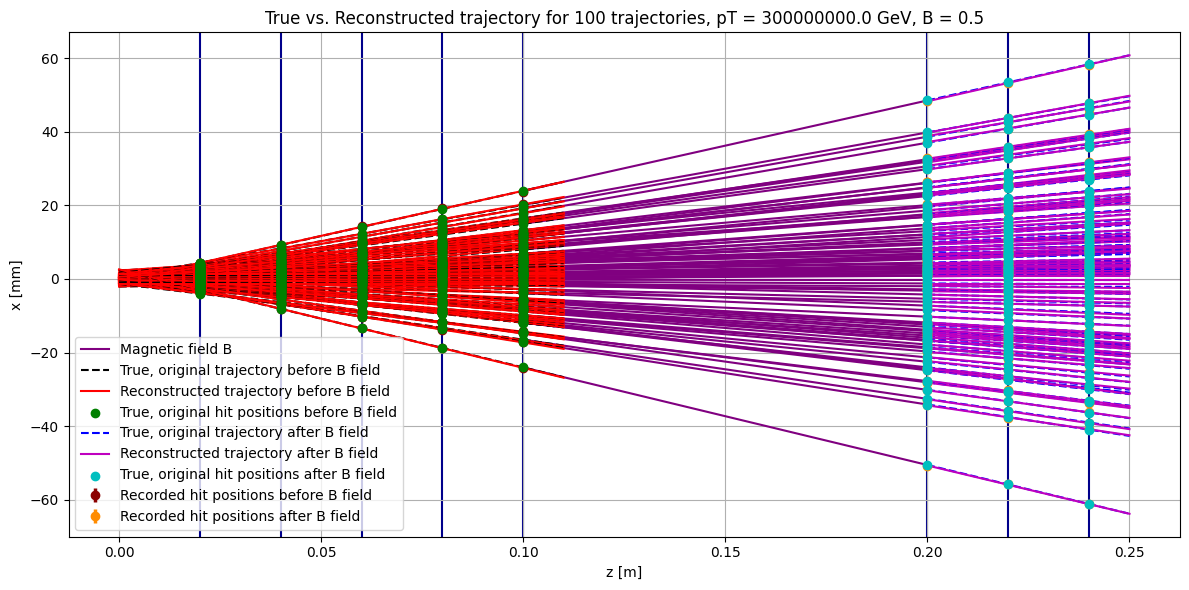

In [ ]:
# Part a)
# Warm-up

#np.random.seed(14)
plt.figure(figsize=(12,6))
# Specify the numbers of trajectories to be generated
z_positions_before_B, z_positions_after_B, x_positions_before_B, x_positions_after_B, grid_before_B, grid_after_B, true_traj_z_before_B, true_traj_z_after_B, reco_traj_z_before_B, reco_traj_z_after_B, cells_hit_middle_before_B, cells_hit_middle_after_B, std_hit, s_after_B, std_x0_reco_before_B, std_s0_reco_before_B, std_x0_reco_after_B, std_s0_reco_after_B, s0, q = simulate_trajectories(nr_trajectories, pT_true, B)

display_simulation(z_positions_before_B, z_positions_after_B, x_positions_before_B, x_positions_after_B, grid_before_B, grid_after_B, true_traj_z_before_B, true_traj_z_after_B, reco_traj_z_before_B, reco_traj_z_after_B, cells_hit_middle_before_B, cells_hit_middle_after_B, std_hit, s_after_B, std_x0_reco_before_B, std_s0_reco_before_B, std_x0_reco_after_B, std_s0_reco_after_B, s0, q, nr_trajectories)


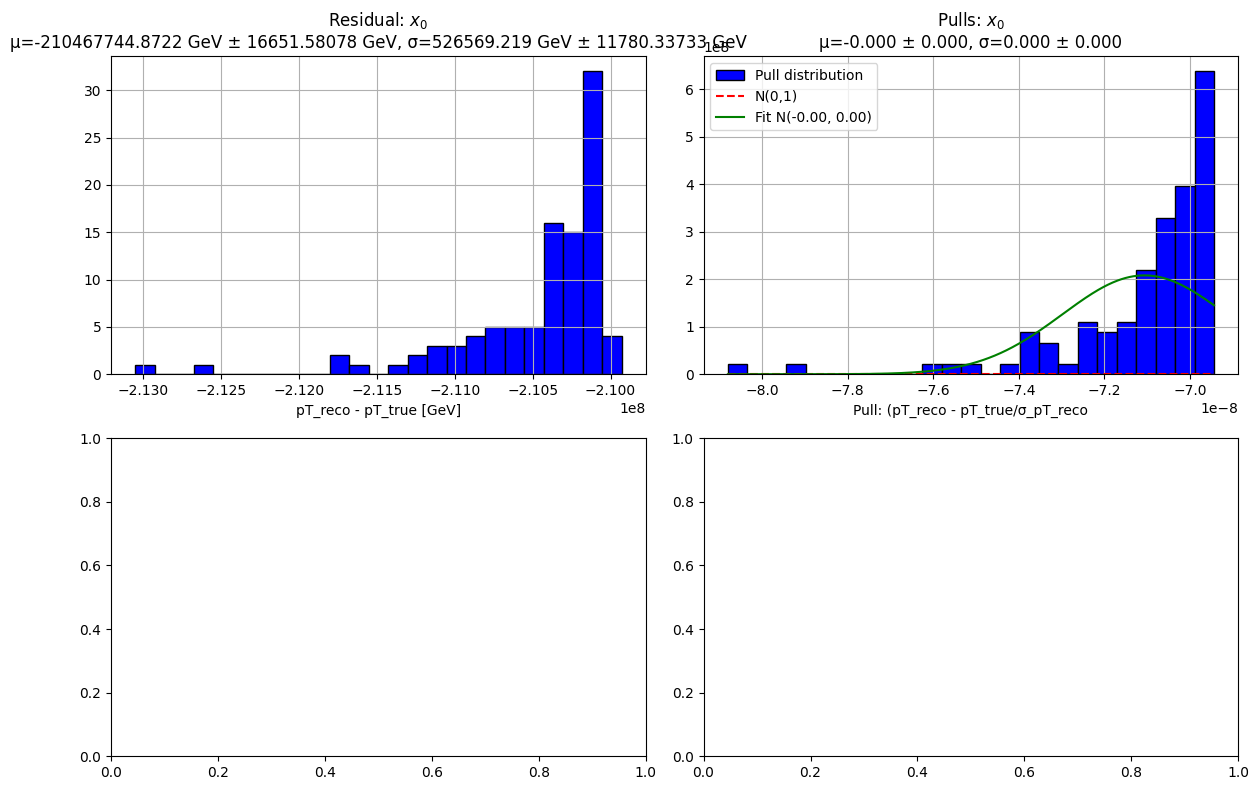

In [76]:
# Compute pT_reco
pT_reco_list = []
pT_reco_err_list = []

for i in range(nr_trajectories):
    pT_reco, pT_reco_err = compute_pT_reco(s0[i], s_after_B[i], std_s0_reco_before_B[i], std_s0_reco_after_B[i], q)
    pT_reco_list.append(pT_reco * const.c / 1e9)
    pT_reco_err_list.append(pT_reco_err * const.c / 1e9)

# Convert the result in GeV
pT_reco_list = np.array(pT_reco_list)   # GeV
pT_reco_err_list = np.array(pT_reco_err_list) # GeV

###################### This code should do d) and e) if pT_reco is the array of the pT reco values, pT_true and pT_reco_err_list similarly.
# Maybe try:
pT_reco = pT_reco_list
pT_reco_err = pT_reco_err_list

##################### Now the code begins:

# Residuals
resi_pT = pT_reco - pT_true

# pull = (reconstructed_quantity - generated_quantity)/uncertainty_on_reconstructed_quantity
pulls_pT = (pT_reco - pT_true)/pT_reco_err

# Taking the mean and standard deviation for the residuals
mean_resi_pT = np.mean(resi_pT)
std_resi_pT = np.std(resi_pT)

# Uncertainties of estimators of residuals assuming gaussian distribution
mean_resi_pT_error = std_resi_pT/np.sqrt(n_trajectories)
std_resi_pT_error = std_resi_pT/np.sqrt(2 * n_trajectories - 2)

# Taking the mean and standard deviation for the pulls
mean_pulls_pT = np.mean(pulls_pT)
std_pulls_pT = np.std(pulls_pT)

# Uncertainties of estimators of pulls assuming gaussian distribution
mean_pulls_pT_error = std_pulls_pT/np.sqrt(n_trajectories)
std_pulls_pT_error = std_pulls_pT/np.sqrt(2 * n_trajectories - 2)

# 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot the distribution of the residuals as histograms
axs[0, 0].hist(resi_pT, bins = 25, color = "blue", edgecolor = "black")
axs[0, 0].set_title(f"Residual: $x_0$\nμ={mean_resi_pT:.4f} GeV ± {mean_resi_pT_error:.5f} GeV, σ={std_resi_pT:.3f} GeV ± {std_resi_pT_error:.5f} GeV")
axs[0, 0].set_xlabel("pT_reco - pT_true [GeV]")
axs[0, 0].grid()

# Plot the distribution of the pulls as histograms with overlayed Gaussian distributions
axs[0, 1].hist(pulls_pT, bins=25, density=True, color="blue", edgecolor="black", label="Pull distribution")
x_vals = np.linspace(min(pulls_pT), max(pulls_pT), 500)
axs[0, 1].plot(x_vals, norm.pdf(x_vals, 0, 1), 'r--', label="N(0,1)")
axs[0, 1].plot(x_vals, norm.pdf(x_vals, mean_pulls_pT, std_pulls_pT), 'g-', label=f"Fit N({mean_pulls_pT:.2f}, {std_pulls_pT:.2f})")
axs[0, 1].set_title(f"Pulls: $x_0$\nμ={mean_pulls_pT:.3f} ± {mean_pulls_pT_error:.3f}, σ={std_pulls_pT:.3f} ± {std_pulls_pT_error:.3f}")
axs[0, 1].set_xlabel("Pull: (pT_reco - pT_true/σ_pT_reco")
axs[0, 1].legend()
axs[0, 1].grid()


plt.tight_layout()
# plt.savefig("Residuals and Pulls")
plt.show()

Repeat the exercise for pT true = 0.1, 1, 2, 5, 10, 20 GeV/c. Observe how the resolution on pT changes as a function of pT true.

Repeat the exercise for pT true = 0.3 GeV and B = 1.0, 1.5, 2.0 T. Observe how the resolution on pT changes as a function of B.

The charge of this iteration is: -1


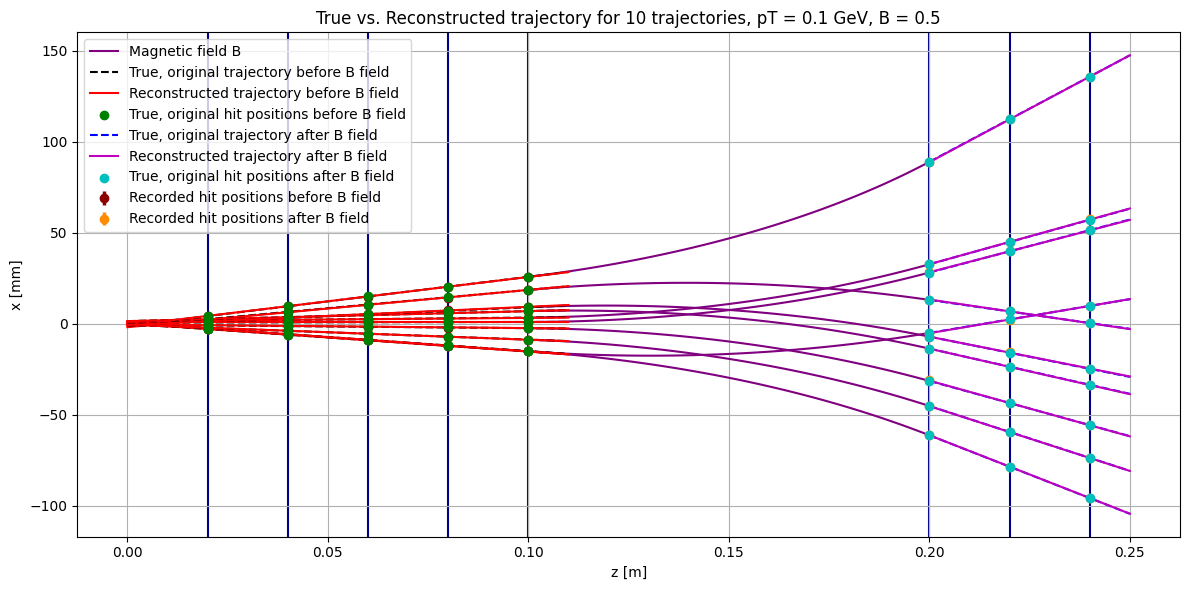

The charge of this iteration is: 1


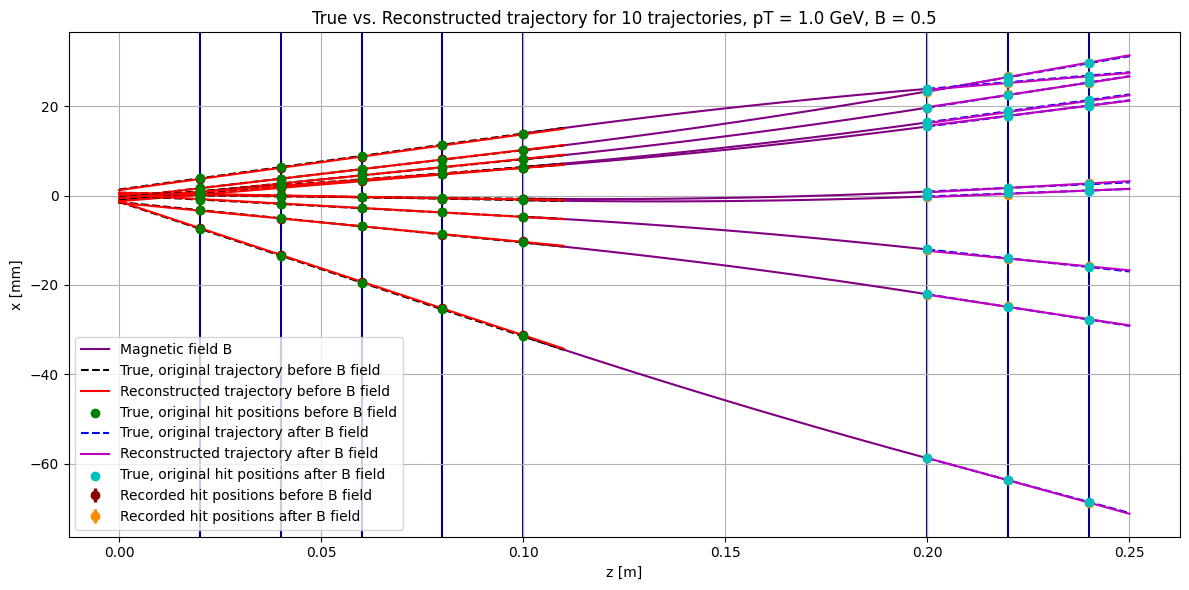

The charge of this iteration is: -1


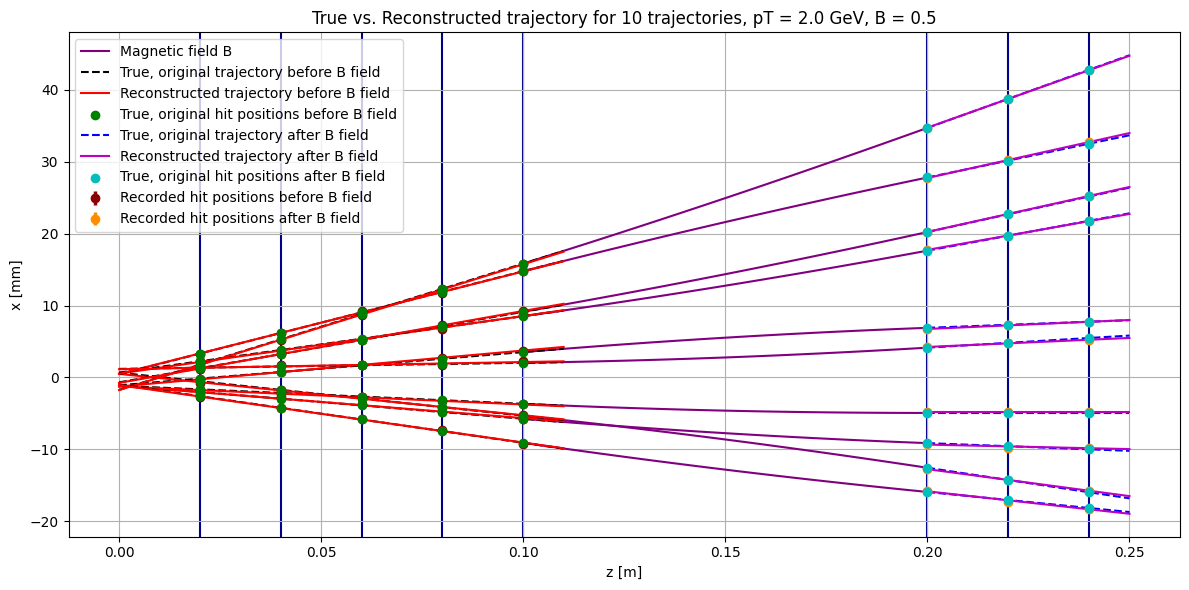

The charge of this iteration is: 1


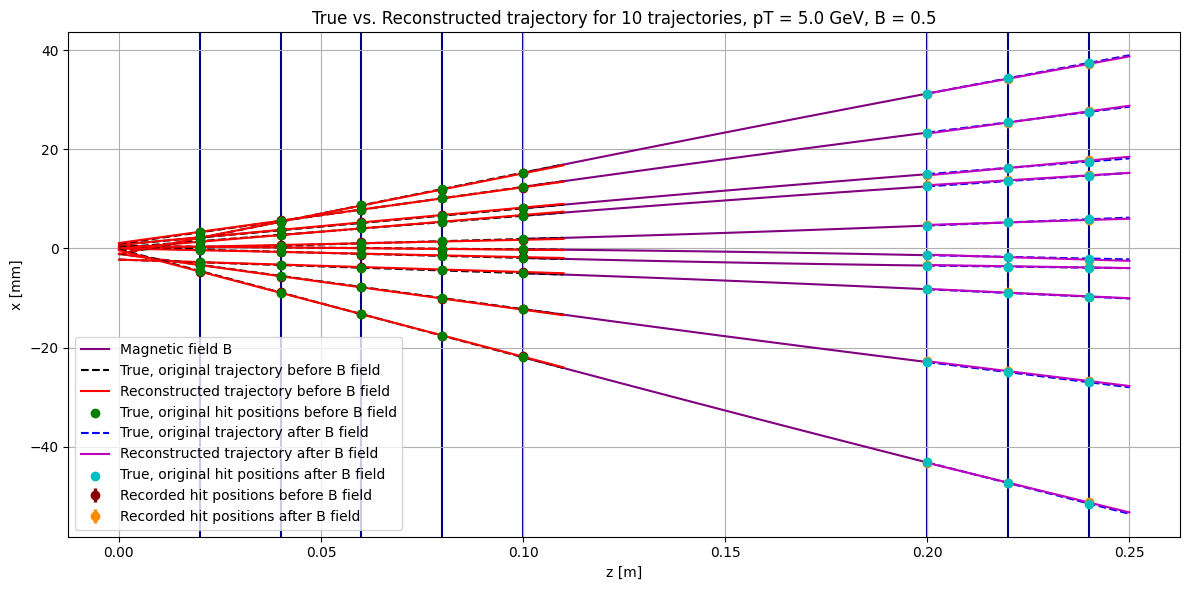

The charge of this iteration is: -1


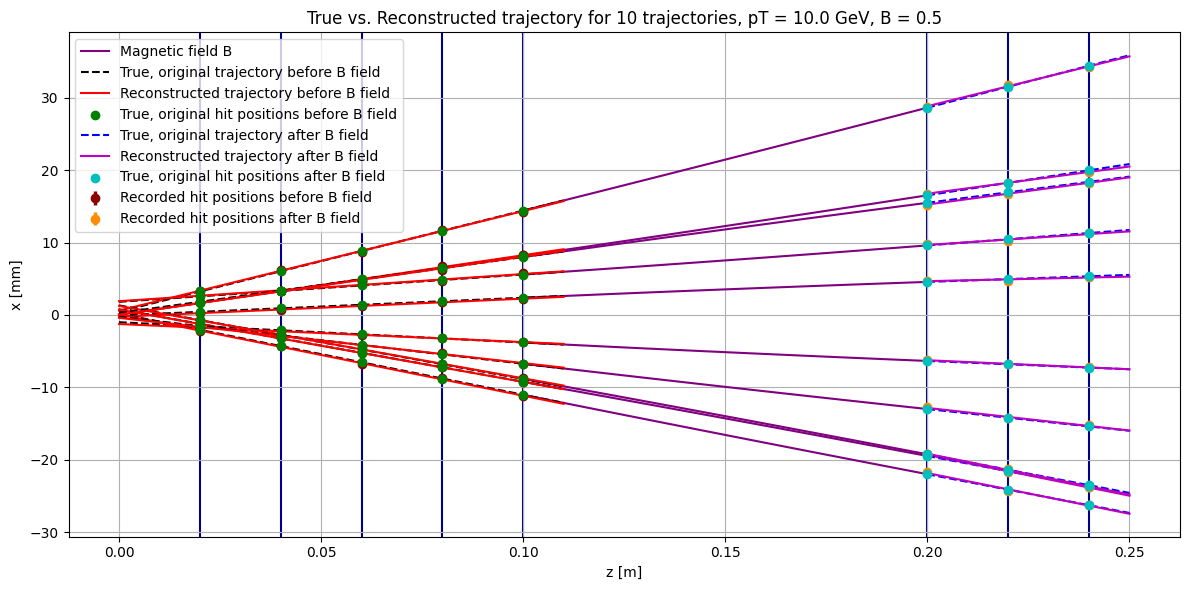

The charge of this iteration is: 1


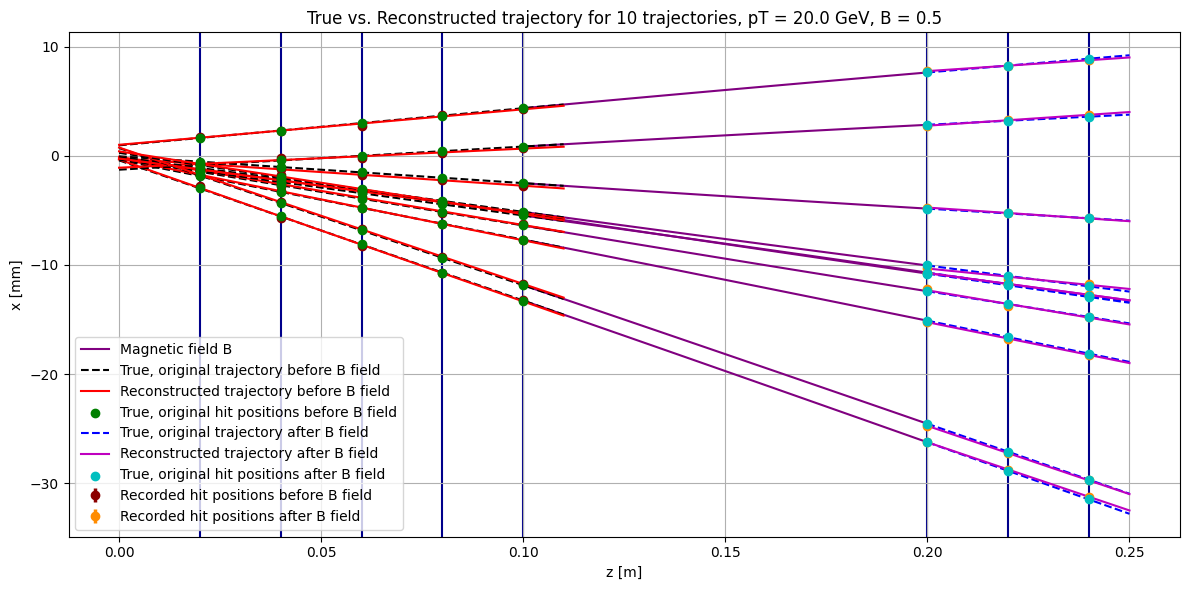

In [ ]:
pT_trues = np.array([0.1, 1, 2, 5, 10, 20]) # GeV/c

# Simulate trajectories for each pT_true value
for pT_true in pT_trues:
    #np.random.seed(14)
    plt.figure(figsize=(12,6))
    # Specify the numbers of trajectories to be generated
    z_positions_before_B, z_positions_after_B, x_positions_before_B, x_positions_after_B, grid_before_B, grid_after_B, true_traj_z_before_B, true_traj_z_after_B, reco_traj_z_before_B, reco_traj_z_after_B, cells_hit_middle_before_B, cells_hit_middle_after_B, std_hit, s_after_B, std_x0_reco_before_B, std_s0_reco_before_B, std_x0_reco_after_B, std_s0_reco_after_B, s0, q = simulate_trajectories(nr_trajectories, pT_true, B)

    display_simulation(z_positions_before_B, z_positions_after_B, x_positions_before_B, x_positions_after_B, grid_before_B, grid_after_B, true_traj_z_before_B, true_traj_z_after_B, reco_traj_z_before_B, reco_traj_z_after_B, cells_hit_middle_before_B, cells_hit_middle_after_B, std_hit, s_after_B, std_x0_reco_before_B, std_s0_reco_before_B, std_x0_reco_after_B, std_s0_reco_after_B, s0, q, nr_trajectories)


The charge of this iteration is: -1


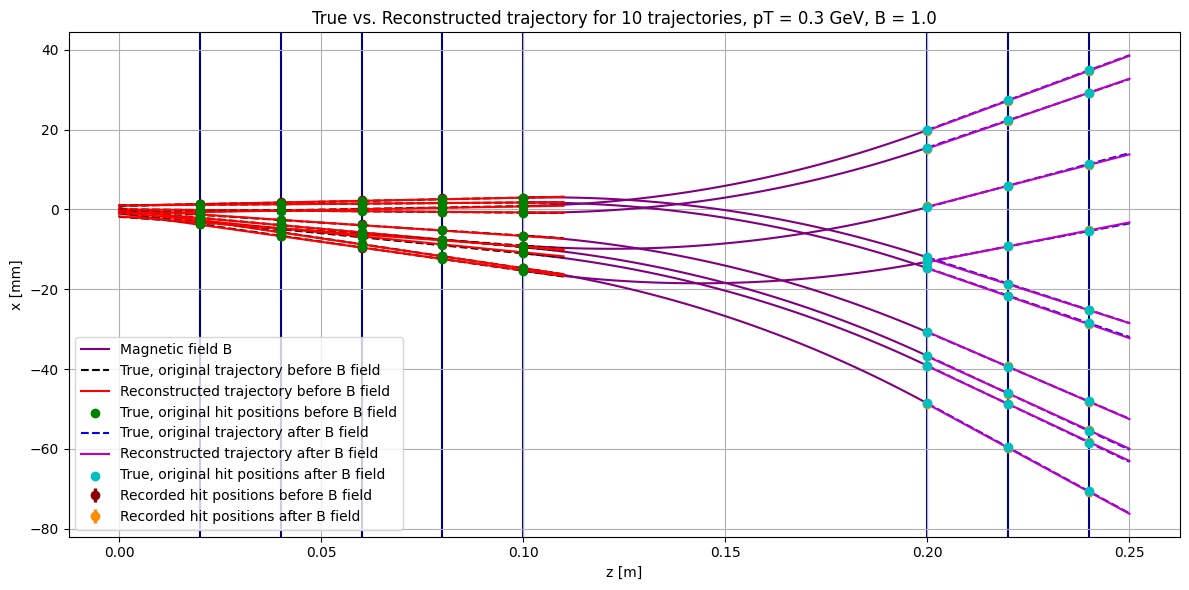

The charge of this iteration is: 1


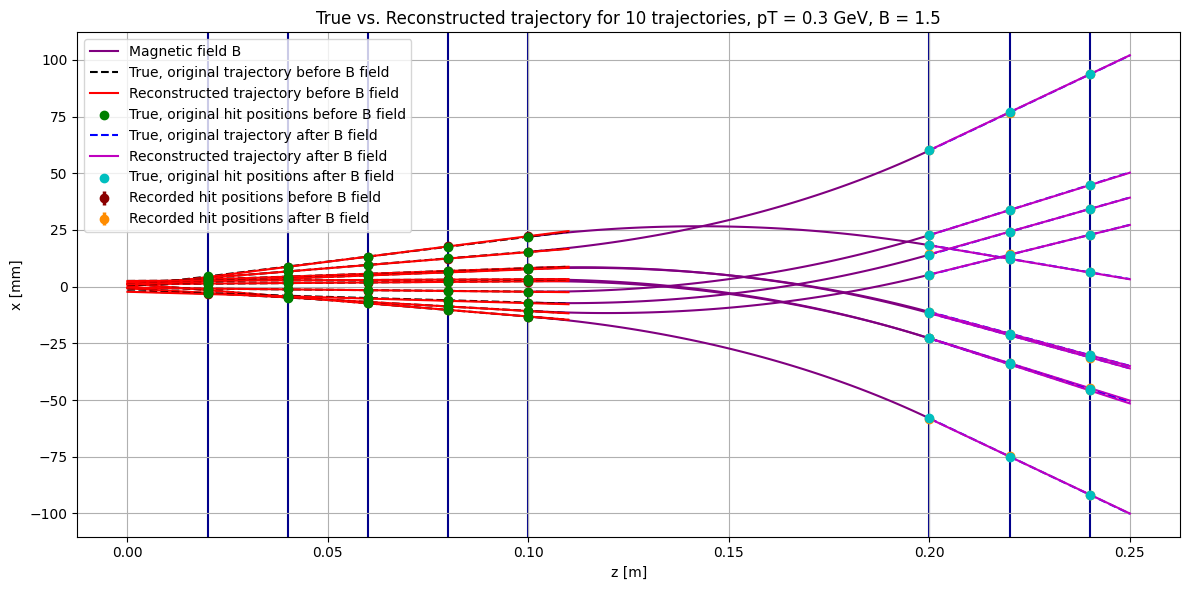

The charge of this iteration is: 1


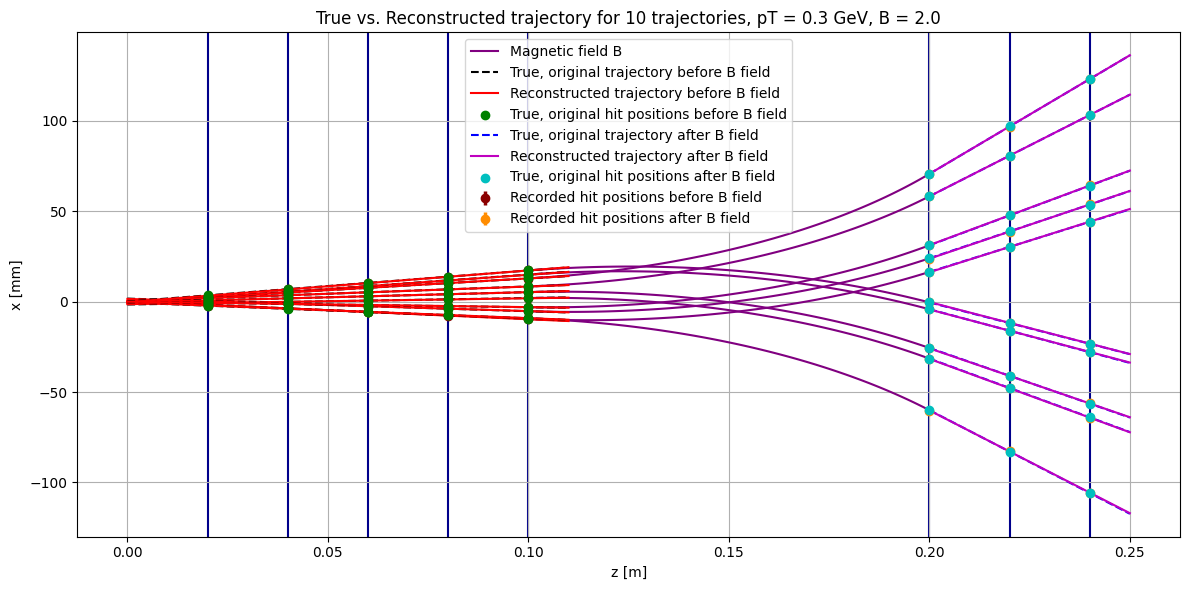

In [ ]:
Bs = np.array([1.0, 1.5, 2.0]) # T
pT_true = 0.3 # GeV/c

# Simulate trajectories for each pT_true value
for B in Bs:
    #np.random.seed(14)
    plt.figure(figsize=(12,6))

    z_positions_before_B, z_positions_after_B, x_positions_before_B, x_positions_after_B, grid_before_B, grid_after_B, true_traj_z_before_B, true_traj_z_after_B, reco_traj_z_before_B, reco_traj_z_after_B, cells_hit_middle_before_B, cells_hit_middle_after_B, std_hit, s_after_B, std_x0_reco_before_B, std_s0_reco_before_B, std_x0_reco_after_B, std_s0_reco_after_B, s0, q = simulate_trajectories(nr_trajectories, pT_true, B)

    display_simulation(z_positions_before_B, z_positions_after_B, x_positions_before_B, x_positions_after_B, grid_before_B, grid_after_B, true_traj_z_before_B, true_traj_z_after_B, reco_traj_z_before_B, reco_traj_z_after_B, cells_hit_middle_before_B, cells_hit_middle_after_B, std_hit, s_after_B, std_x0_reco_before_B, std_s0_reco_before_B, std_x0_reco_after_B, std_s0_reco_after_B, s0, q, nr_trajectories)
